In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [4]:
linear_train_df = pd.read_csv('combined_data/linear_train_data.csv')
linear_val_df = pd.read_csv('combined_data/linear_val_data.csv')
linear_test_df = pd.read_csv('combined_data/linear_test_data.csv')
non_linear_train_df = pd.read_csv('combined_data/non_linear_train_data.csv')
non_linear_val_df = pd.read_csv('combined_data/non_linear_val_data.csv')
non_linear_test_df = pd.read_csv('combined_data/non_linear_test_data.csv')
overlapping_train_df = pd.read_csv('combined_data/overlapping_train_data.csv')
overlapping_val_df = pd.read_csv('combined_data/overlapping_val_data.csv')
overlapping_test_df = pd.read_csv('combined_data/overlapping_test_data.csv')

In [5]:
class DiagonalCovarianceBayesClassifier:
    def __init__(self):
        self.class_means = None
        self.class_cov_matrices = None
        self.class_priors = None
        self.num_classes = 0

    def fit(self, train_data, train_labels):
        self.num_classes = len(np.unique(train_labels))
        self.class_means = {}
        self.class_cov_matrices = {}
        self.class_priors = {}

        for class_label in range(self.num_classes):
            class_data = train_data[train_labels == class_label]
            class_mean = np.mean(class_data, axis=0)
            class_cov_matrix = np.diag(np.var(class_data, axis=0))
            class_prior = len(class_data) / len(train_data)

            self.class_means[class_label] = class_mean
            self.class_cov_matrices[class_label] = class_cov_matrix
            self.class_priors[class_label] = class_prior

    def calculate_likelihood(self, x, class_label):
        class_mean = self.class_means[class_label]
        class_cov_matrix = self.class_cov_matrices[class_label]
        
        # Calculate the likelihood using the Gaussian density function
        exponent = -0.5 * np.sum((x - class_mean) ** 2 / np.diag(class_cov_matrix))
        likelihood = (1.0 / (np.sqrt((2 * np.pi) ** len(x) * np.prod(np.diag(class_cov_matrix)))) *
                      np.exp(exponent))
        
        return likelihood

    def predict(self, X):
        predicted_labels = []

        for x in X:
            posteriors = []

            for class_label in range(self.num_classes):
                prior = self.class_priors[class_label]
                likelihood = self.calculate_likelihood(x, class_label)
                posterior = prior * likelihood
                posteriors.append(posterior)

            predicted_label = np.argmax(posteriors)
            predicted_labels.append(predicted_label)

        return np.array(predicted_labels)
    

In [6]:
class1_train_data = linear_train_df[['X', 'Y']].values  # Extract class 0 training data
class2_train_data = non_linear_train_df[['X', 'Y']].values  # Extract class 1 training data
class3_train_data = overlapping_train_df[['X', 'Y']].values  # Extract class 2 training data

In [7]:
train_data = np.vstack((class1_train_data, class2_train_data, class3_train_data))
train_labels = np.hstack((np.zeros(len(class1_train_data)), np.ones(len(class2_train_data)), 2*np.ones(len(class3_train_data))))


In [8]:
classifier = DiagonalCovarianceBayesClassifier()
classifier.fit(train_data, train_labels)

In [9]:
test1_data = linear_test_df[['X', 'Y']].values 
test1_labels = linear_test_df['Label'].values  
test1_predicted_labels = classifier.predict(test1_data)

test2_data = non_linear_test_df[['X', 'Y']].values 
test2_labels = non_linear_test_df['Label'].values  
test2_predicted_labels = classifier.predict(test2_data)

test3_data = overlapping_test_df[['X', 'Y']].values 
test3_labels = overlapping_test_df['Label'].values  
test3_predicted_labels = classifier.predict(test3_data)

In [13]:
accuracy = round(accuracy_score(test1_labels, test1_predicted_labels), 2)
print(f"Accuracy: {accuracy}")

Accuracy: 0.0


/var/folders/0d/nr7p020970b51ht781dxqwsr0000gn/T/ipykernel_64761/179525417.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.6, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')


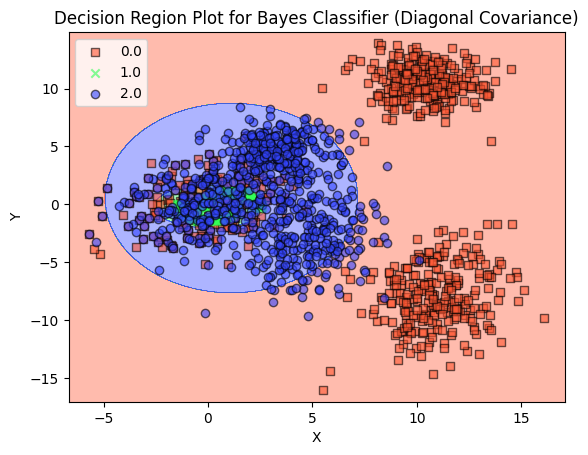

In [11]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o')
    colors = ('#FF5733', '#33FF57', '#3344FF')
    cmap = ListedColormap(colors)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution), np.arange(y_min, y_max, resolution))
    
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.6, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')

# Example usage:
X_train = train_data
y_train = train_labels

plot_decision_regions(X_train, y_train, classifier=classifier)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper left')
plt.title('Decision Region Plot for Bayes Classifier (Diagonal Covariance)')
plt.show()

In [12]:
linear_confusion_matrix = confusion_matrix(test1_labels, test1_predicted_labels)
non_linear_confusion_matrix = confusion_matrix(test2_labels, test2_predicted_labels)
overlapping_confusion_matrix = confusion_matrix(test3_labels, test3_labels)

ValueError: Mix of label input types (string and number)

In [ ]:
linear_confusion_matrix_percentage = linear_confusion_matrix.astype('float') / linear_confusion_matrix.sum(axis=1)[:, np.newaxis] * 100
non_linear_confusion_matrix_percentage = non_linear_confusion_matrix.astype('float') / non_linear_confusion_matrix.sum(axis=1)[:, np.newaxis] * 100
overlapping_confusion_matrix_percentage = overlapping_confusion_matrix.astype('float') / overlapping_confusion_matrix.sum(axis=1)[:, np.newaxis] * 100

In [ ]:
def plot_heatmaps(heatmaps, titles, x_labels, y_labels, cmaps = ['Blues', 'Greens', 'Reds']):
    """
    Plot a list of heatmaps in a side-by-side layout.

    Args:
        heatmaps (list of 2D arrays): List of confusion matrices or heatmaps.
        titles (list of str): Titles for each heatmap.
        x_labels (list of str): X-axis labels for each heatmap.
        y_labels (list of str): Y-axis labels for each heatmap.
        cmaps (list of str): Colour maps for each heatmap.

    """
    num_heatmaps = len(heatmaps)
    num_rows = 1
    num_cols = num_heatmaps

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 6))

    if num_heatmaps == 1:
        axes = [axes]

    # Loop through each heatmap and plot it
    for i in range(num_heatmaps):
        ax = axes[i]
        if(i == 1):
            x_, y_ = x_labels[:-1], y_labels[:-1]
        else:
            x_, y_ = x_labels, y_labels
            
        sns.heatmap(np.transpose(heatmaps[i])/100, annot=True, 
                    cmap=cmaps[i], fmt=".2%", 
                    annot_kws={"size": 16}, square=True,
                    xticklabels=x_, yticklabels=y_, ax=ax)
        ax.set_title(titles[i])
        ax.set_xlabel('Actual Labels')
        ax.set_ylabel('Predicted Labels')

    plt.tight_layout()
    plt.show()

In [ ]:
def calculate_metrics_and_accuracy(test_labels, predicted_labels):
    """
    Calculate precision, recall, F1 score, and accuracy based on test and predicted labels.

    Parameters:
    - test_labels (array-like): True labels from the test data.
    - predicted_labels (array-like): Predicted labels from a classification model.

    Returns:
    - accuracy_df (pd.DataFrame): DataFrame containing the accuracy of the model on the test data.
    - metrics_df (pd.DataFrame): DataFrame containing precision, recall, and F1 score for each class and their mean.

    """
    
    num_classes = len(np.unique(test_labels))
    recision_per_class = precision_score(test_labels, predicted_labels, average=None)
    recall_per_class = recall_score(test_labels, predicted_labels, average=None)
    f1_score_per_class = f1_score(test_labels, predicted_labels, average=None)

    mean_precision = np.mean(precision_per_class)
    mean_recall = np.mean(recall_per_class)
    mean_f1_score = np.mean(f1_score_per_class)

    precision_per_class = np.round(np.append(precision_per_class, mean_precision), 2)
    recall_per_class = np.round(np.append(recall_per_class, mean_recall), 2)
    f1_score_per_class = np.round(np.append(f1_score_per_class, mean_f1_score), 2)

    metrics_df = pd.DataFrame({
        'Class': [f'Class {i + 1}' for i in range(num_classes)] + ['Mean'],
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1 Score': f1_score_per_class
    })

    test_accuracy = round(accuracy_score(test_labels, predicted_labels), 2)
    accuracy_df = pd.DataFrame({'Accuracy': [test_accuracy]})

    return accuracy_df, metrics_df

In [ ]:
def plot_accuracy_and_metrics(test_labels, predicted_labels, data_type):
    """
    Plot accuracy and metrics tables side by side with a title.

    Parameters:
    - test_labels (array-like): True labels from the test data.
    - predicted_labels (array-like): Predicted labels from a classification model.
    - data_type (str): A string indicating the type of test data (e.g., 'Validation', 'Testing').

    """
    accuracy_df, metrics_df = calculate_metrics_and_accuracy(test_labels, predicted_labels)
    
    fig, ax = plt.subplots(figsize=(6, 2.5))

    data1 = [accuracy_df.columns.tolist()] + accuracy_df.values.tolist()
    data2 = [metrics_df.columns.tolist()] + metrics_df.values.tolist()

    table1 = ax.table(cellText=data1, loc='upper center', cellLoc='center')
    table1.auto_set_font_size(False)
    table1.set_fontsize(12)
    table1.scale(0.25, 1.25)  # Adjust the table size

    table2 = ax.table(cellText=data2, loc='lower center', cellLoc='center')
    table2.auto_set_font_size(False)
    table2.set_fontsize(12)
    table2.scale(1, 1.5)  # Adjust the table size

    ax.axis('off')

    plt.subplots_adjust(top=1.0, bottom=0.1)
    plt.title(f'1NN Performance on {data_type} Test Data')
    plt.show()

In [ ]:
plot_accuracy_and_metrics(test1_labels, test1_predicted_labels, 'Linearly Separable')
plot_accuracy_and_metrics(test2_labels, test2_predicted_labels, 'Non Linearly Separable')
plot_accuracy_and_metrics(test3_labels, test3_predicted_labels, 'Overlapping')

In [ ]:
def decision_region_plot(train_df, clf, data_type):
    # Define color pairs
    color_pairs = [('#FF5733', '#33FF57'), ('#FF5733', '#3344FF'), ('#33FF57', '#3344FF')]

    # Create colormaps
    colormaps = []
    for color1, color2 in color_pairs:
        cmap_name = f'custom_{color1}_{color2}'
        cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, [color1, color2], N=256)
        colormaps.append(cmap)

    x_min, x_max = train_df['X'].min() - 1, train_df['X'].max() + 1
    y_min, y_max = train_df['Y'].min() - 1, train_df['Y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    class_mapping = {label: i + 1 for i, label in enumerate(train_df['Label'].unique())}

    class_pairs = []
    num_classes = len(class_mapping)
    
    if num_classes == 2:
        class_pairs.append((list(class_mapping.keys())[0], list(class_mapping.keys())[1]))
    else:
        class_pairs = [(class1, class2) for class1 in train_df['Label'].unique() for class2 in train_df['Label'].unique() if class1 < class2]

    num_plots = len(class_pairs)

    plt.figure(figsize=(15, 8))
    plt.suptitle(f"Decision Region plot for every pair of classes of {data_type} Data")
    
    for i, (class1, class2) in enumerate(class_pairs, 1):
        plt.subplot(1, num_plots, i)

        df_pair = train_df[(train_df['Label'] == class1) | (train_df['Label'] == class2)]

        X_pair = df_pair[['X', 'Y']].values
        y_pair = df_pair['Label'].values

        clf.fit(X_pair, y_pair)

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        Z = np.vectorize(class_mapping.get)(Z)

        # Plot the decision boundary using the specified colormap
        plt.contourf(xx, yy, Z, cmap=colormaps[i-1], alpha=0.8)

        # Plot the decision boundary contour lines
        plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

        # Plot the training data points
        plt.scatter(X_pair[:, 0], X_pair[:, 1], c=[1 if label == class1 else 2 for label in y_pair],
                    cmap=colormaps[i-1], edgecolor='k', s=20)

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'{class1} vs. {class2}')

    plt.tight_layout()
    plt.show()

## Working Pending Henceforth ##

In [ ]:
decision_region_plot(linear_train_df, KNeighborsClassifier(n_neighbors=1), 'Linearly Separable')
decision_region_plot(non_linear_train_df, KNeighborsClassifier(n_neighbors=1), 'Non Linearly Separable')
decision_region_plot(overlapping_train_df, KNeighborsClassifier(n_neighbors=1), 'Overlapping')


In [ ]:
def decision_region_plot_all_classes(train_df, clf, data_type):
    # Define custom colormap with the three specified colors
    custom_colors = ['#FF5733', '#33FF57', '#3344FF']
    cmap = ListedColormap(custom_colors)

    x_min, x_max = train_df['X'].min() - 1, train_df['X'].max() + 1
    y_min, y_max = train_df['Y'].min() - 1, train_df['Y'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    class_mapping = {label: i + 1 for i, label in enumerate(train_df['Label'].unique())}

    num_classes = len(class_mapping)

    plt.figure(figsize=(10, 6))
    plt.suptitle(f"Decision Region plot for all classes of {data_type} Data")

    X_all = train_df[['X', 'Y']].values
    y_all = train_df['Label'].values

    clf.fit(X_all, y_all)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = np.vectorize(class_mapping.get)(Z)

    # Plot the decision boundary using the custom colormap
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.8)

    # Plot the decision boundary contour lines
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

    # Plot the training data points
    scatter = plt.scatter(X_all[:, 0], X_all[:, 1], 
                          c=[1 if label == 'Class 1' else (2 if label == 'Class 2' else 3) for label in y_all], 
                          cmap=cmap, edgecolor='k', s=20)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(*scatter.legend_elements(), title='Classes', loc='best')

    plt.tight_layout()
    plt.show()
    

In [ ]:
decision_region_plot_all_classes(linear_train_df, KNeighborsClassifier(n_neighbors=1), 'Linearly Separable')
decision_region_plot_all_classes(non_linear_train_df, KNeighborsClassifier(n_neighbors=1), 'Non Linearly Separable')
decision_region_plot_all_classes(overlapping_train_df, KNeighborsClassifier(n_neighbors=1), 'Overlapping')

In [ ]:
def decision_region_plot_test_points(train_df, test_df, clf, data_type):

    colormap = mcolors.ListedColormap(['#FF5733', '#33FF57', '#3344FF'])

    x_min, x_max = min(train_df['X'].min(), test_df['X'].min()) - 1, max(train_df['X'].max(), test_df['X'].max()) + 1
    y_min, y_max = min(train_df['Y'].min(), test_df['Y'].min()) - 1, max(train_df['Y'].max(), test_df['Y'].max()) + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    class_mapping = {label: i for i, label in enumerate(train_df['Label'].unique())}

    num_classes = len(class_mapping)

    plt.figure(figsize=(10, 6))
    plt.title(f"Decision Region plot for all classes of {data_type} Test Data")

    df_train = train_df.copy()
    df_test = test_df.copy()

    X_train = df_train[['X', 'Y']].values
    y_train = df_train['Label'].values
    
    # y_train = df_train['Label'].map(class_mapping).values

    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    Z = np.vectorize(class_mapping.get)(Z)


    # Plot the decision regions using the specified colormap
    plt.contourf(xx, yy, Z, cmap=colormap, alpha=0.8, levels=np.arange(num_classes + 1) - 0.5)

    # Plot the decision boundary contour lines
    plt.contour(xx, yy, Z, colors='k', linewidths=0.5)

    # Plot the testing data points
    X_test = df_test[['X', 'Y']].values
    y_test = df_test['Label'].values
    scatter = plt.scatter(X_test[:, 0], X_test[:, 1], 
                          c=[1 if label == 'Class 1' else (2 if label == 'Class 2' else 3) for label in y_test],
                          cmap=colormap, edgecolor='k', s=30, label='Testing Data')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(*scatter.legend_elements(), title='Classes', loc='best')
    
    plt.tight_layout()
    plt.show();
    

In [ ]:
decision_region_plot_test_points(linear_train_df, linear_test_df, KNeighborsClassifier(n_neighbors=1), 'Linearly Separable')
decision_region_plot_test_points(non_linear_train_df, non_linear_test_df, KNeighborsClassifier(n_neighbors=1), 'Non Linearly Separable')
decision_region_plot_test_points(overlapping_train_df, overlapping_test_df, KNeighborsClassifier(n_neighbors=1), 'Overlapping')
    